In [7]:
#!pip install control
#!pip install slycot
#!pip install plotly
#!pip install nbformat
#!pip install SciencePlots
#!pip install latex


In [1]:
# importa os modulo necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import control as ct
from slycot import *
import scienceplots
import latex



# 1 Modelagem pelo módulo Sympy

In [2]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, m3, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 m3 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x,u ,theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [3]:
# Definindo as derivadas no tempo 

x = x(t)  # Posição x do carro 
u = u(t)  # Variável de controle
phi1 = phi1(t) # Ângulo do pêndulo inferior
phi2 = phi2(t) # Ângulo do pêndulo superior
theta1 = theta1(t) # Ângulo do linearizado 
theta2 = theta2(t) # Ângulo do linearizado

x_d = sym.diff(x, t) # Velocidade do carro
phi1_d = sym.diff(phi1, t) # Velocidade angular do pendulo inferior
phi2_d = sym.diff(phi2, t) # Velocidade angular do pendulo superior

x_dd = sym.diff(x_d, t) # Aceleração do carro
phi1_dd = sym.diff(phi1_d, t) # Aceleração angular do pendulo inferior
phi2_dd = sym.diff(phi2_d, t) # Aceleração angular do pendulo superior

# Simplificação
dpdp2=phi2_d*phi2_d
dpdp1=phi1_d*phi1_d
dxdx=x_d*x_d

In [5]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial carro:
Kc = 1/2 * M *dxdx
Pc = 0

# Energia cinética e potencial do pendulo inferior:
Kp_1 = 1/2 * m1  *dxdx + m1* x_d*l1*phi1_d*sym.cos(phi1)+ 1/2 *dpdp1*(m1*l1*l1+J1)
Pp_1 = m1*g*l1*sym.cos(phi1)

# Energia cinética e potencial do pendulo superior:
Kp_2 = 1/2 *m2*(dxdx + 2*x_d*(2*l1*phi1_d*sym.cos(phi1)+l2*phi2_d*sym.cos(phi2)))\
+1/2 *m2*(4*l1*l1*dpdp1+l2*l2*dpdp2+4*l1*l2*phi1_d*phi2_d*sym.cos(phi1-phi2))+1/2 *J2*dpdp2
Pp_2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))

# Energia cinética e potencial total:
P_total = Pc + Pp_1 + Pp_2
K_total = Kc + Kp_1 + Kp_2 
L = K_total - P_total
L

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*l1*m1*cos(phi1(t)) - g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t))) + l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*(2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t))*Derivative(x(t), t) + Derivative(x(t), t)**2) + 0.5*m2*(4*l1**2*Derivative(phi1(t), t)**2 + 4*l1*l2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + l2**2*Derivative(phi2(t), t)**2) + 0.5*(J1 + l1**2*m1)*Derivative(phi1(t), t)**2

In [6]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eqnx = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d



# Solução das equaçoes das variáveis generalizadas
# Solução para X
sol_xdd = sym.solve(eqnx, x_dd)[0]
# Solução para phi1
sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
# Solução para phi1
sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]

In [7]:
# Matriz dos estados
q = sym.Matrix([x,theta1,theta2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_dd.transpose()])


# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1):theta1,sym.sin(phi2):theta2}


In [8]:
# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eqnx,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H

Matrix([
[1.0*M + 1.0*m1 + 1.0*m2,                    l1*m1 + 2.0*l1*m2,             1.0*l2*m2],
[      l1*m1 + 2.0*l1*m2, 1.0*J1 + 1.0*l1**2*m1 + 4.0*l1**2*m2,          2.0*l1*l2*m2],
[              1.0*l2*m2,                         2.0*l1*l2*m2, 1.0*J2 + 1.0*l2**2*m2]])

In [9]:
N = sym.Matrix((sym.diff(eqnx,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

Matrix([
[f0,       0,   0],
[ 0, f1 + f2, -f2],
[ 0,     -f2,  f2]])

In [10]:
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs(ponto_eq)
W

Matrix([
[                          0],
[-g*l1*(m1 + 2*m2)*theta1(t)],
[         -g*l2*m2*theta2(t)]])

In [11]:
# Matriz de entradas
V = sym.Matrix([u,0,0])
V

Matrix([
[u(t)],
[   0],
[   0]])

In [12]:
# Multiplicação matricial

C = N*q_d.transpose() + W
S = (H_inv*C).subs(ponto_eq)
S

Matrix([
[                                  -g*l1*(m1 + 2*m2)*(-1.0*J2*l1*m1 - 2.0*J2*l1*m2 - 1.0*l1*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - g*l2*m2*(-1.0*J1*l2*m2 + 1.0*l1**2*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2)],
[                 -g*l1*(m1 + 2*m2)*(1.0*J2*M + 1.0*J2*m1 + 1.0*J2*m2 + 1.0*M*l2**2*m2 + 1.0*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - g*l2*m2*(-2.0*M*l1*l2*m2 - 1.0*l1*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0

In [13]:
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_0

Matrix([
[                                                                                                                                                                                                                                                  Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi1(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi2(t), (t, 2))],
[(1.0*J1*J2 + 1.0*J1*l2**2*m2 + 1.0*J2*l1**2*m1 + 4.0*J2*l1**2*m2 + 1.0*l1**2*l2**2*m1*m2)*u(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 +

In [14]:
# Solução Final 
f = sym.Matrix([q_dd.transpose(),S])
f

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [15]:
f_s = f.jacobian(q_ef)
f_s

Matrix([
[0,                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                           0, 1, 0, 0],
[0,                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                       

In [16]:
# Obtendo as matrizes numericas de estados A 

# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}
valor_param_Yadav = {M:0.8,m1:0.5,m2:0.3,J1:0.006,J2:0.006,\
               l1:0.15,l2:0.15,g:9.81,f0:0.01,f1:0.007,f2:0.007}
# Matriz A
A_s = f_s.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A

matrix([[   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            1.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    1.        ],
        [   0.        ,   14.73466591,   -1.64374696,    0.        ,
            0.        ,    0.        ],
        [   0.        , -442.33526109,  147.64194295,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  442.92582886, -344.30101097,    0.        ,
            0.        ,    0.        ]])

In [17]:
# Matriz B
b_i = B_0.jacobian([u])
B_s = b_i.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
#b_i
B

matrix([[  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.77814879],
        [-10.01336453],
        [  3.35116609]])

In [29]:
# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])

# Matriz D
D = np.zeros((6,1))

In [26]:
#Entradas aumentadas com pertubação e ruido
Bf = np.hstack((B, Vd, np.zeros_like(B))) 

# Cria um grande sistema em espaço de estados com uma entrada simples
sysC = ct.ss(A, Bf, C, np.array([0,0,0,0,0,0,0,Vn]))

# Sistema com todas as saidas de estado, pertubações e sem ruido
SysFullOutput = ct.ss(A,Bf, np.eye(6),np.zeros([6,np.size(Bf,1)]))

In [ ]:
# Discretização
sys = ct.ss(A,B,C,D)
Ts = 0.01

sys_discreto = ct.c2d(sys,Ts, method='zoh')

Ad = sys_discreto.A
Bd = sys_discreto.B
Cd = sys_discreto.C

# 2 Modelagem pelo módulo Numpy

# 3 Estabilidade

In [ ]:
# Criando o sistema em State Space
sys = ct.ss(A,B,C,D)
print(sys_discreto)


In [20]:
#Exibir Matriz discreta A
sym.Matrix(sys_discreto.A)


Matrix([
[1.0, 0.000733720376049382, -8.10478922770698e-5, 0.01,  2.44974831146228e-6, -2.71677320385037e-7],
[  0,    0.977991778268197,  0.00733381421081525,    0,  0.00992649467136372,  2.45103624070375e-5],
[  0,   0.0220014426324457,    0.982861430904178,    0,  7.35310872211124e-5,  0.00994276955200199],
[  0,    0.146142716106745,  -0.0159822452723519,  1.0, 0.000733720376049382, -8.10478922770698e-5],
[  0,    -4.37998233958085,     1.45712801744595,    0,    0.977991778268197,  0.00733381421081525],
[  0,     4.37138405233785,    -3.41244933599674,    0,   0.0220014426324457,    0.982861430904178]])

In [21]:
#Exibir Matriz discreta B

sym.Matrix(sys_discreto.B)

Matrix([
[  3.88437813038502e-5],
[-0.000498620710872838],
[ 0.000165235254387502],
[  0.00775604725906874],
[   -0.099315471360343],
[   0.0325835785369049]])

In [22]:
#Exibir Matriz discreta C

sym.Matrix(sys_discreto.C)

Matrix([
[1.0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0, 1.0]])

In [23]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz de controlabilidade: 6


Matrix([
[  3.88437813038502e-5, 0.000115772863622379, 0.000190466742827359, 0.000261566913824604, 0.000327903743276532, 0.000388555438773389],
[-0.000498620710872838, -0.00147149101297509, -0.00237272557931563, -0.00315939801542793, -0.00379550293804701, -0.00425409579994399],
[ 0.000165235254387502, 0.000468101221582499, 0.000690172168305373,  0.00078417921680752, 0.000712284217549139, 0.000448961073428659],
[  0.00775604725906874,  0.00760502602835415,  0.00731098925527181,  0.00688945190513187,  0.00636247735163702,  0.00575731388628023],
[   -0.099315471360343,  -0.0944660337075228,  -0.0850610952510404,  -0.0716697030327761,  -0.0550995812134601,   -0.036345452776279],
[   0.0325835785369049,   0.0270965394213194,   0.0165239304368125,  0.00164199479041631,   -0.016449897457841,   -0.036402474847977]])

In [24]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cd)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                    0,                     0,    0,                    0,                     0],
[  0,                  1.0,                     0,    0,                    0,                     0],
[  0,                    0,                   1.0,    0,                    0,                     0],
[  0,                    0,                     0,  1.0,                    0,                     0],
[  0,                    0,                     0,    0,                  1.0,                     0],
[  0,                    0,                     0,    0,                    0,                   1.0],
[1.0, 0.000733720376049382,  -8.10478922770698e-5, 0.01,  2.44974831146228e-6,  -2.71677320385037e-7],
[  0,    0.977991778268197,   0.00733381421081525,    0,  0.00992649467136372,   2.45103624070375e-5],
[  0,   0.0220014426324457,     0.982861430904178,    0,  7.35310872211124e-5,   0.00994276955200199],
[  0,    0.146142716106745,   -0.0159822452723519,  1.0, 0.00073

In [25]:
# Polos do sistema
polos = ct.poles(sys_discreto)
zeros_s = ct.zeros(sys_discreto)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

Os polos do sistema são:  [1.        +0.j         1.        +0.j         0.96749282+0.2528985j
 0.96749282-0.2528985j  0.99336039+0.11504404j 0.99336039-0.11504404j] Os zeros do sistema são:  []


(array([1.        +0.j        , 1.        +0.j        ,
        0.96749282+0.2528985j , 0.96749282-0.2528985j ,
        0.99336039+0.11504404j, 0.99336039-0.11504404j]),
 array([], dtype=float64))

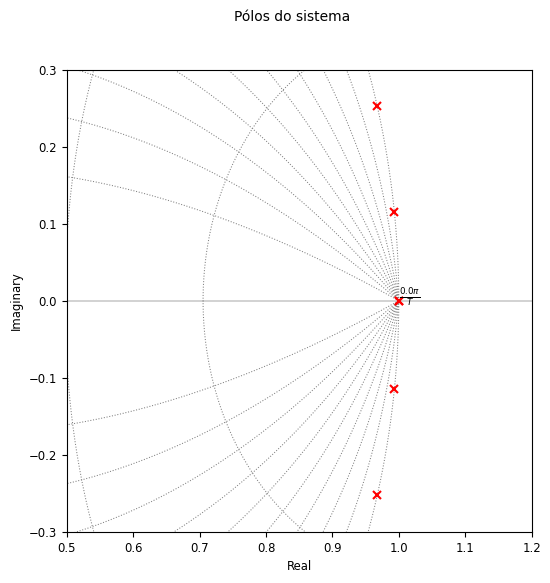

In [26]:
# Pólos do sistema

plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_discreto,plot=True,title ='Pólos do sistema',grid=True,marker_color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)


In [27]:
# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])
tp = np.arange(0, 3, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

In [28]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'bright',
 'cjk-jp-font',
 'cjk-kr-font',
 'cjk-sc-font',
 'cjk-tc-font',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'grid',
 'high-contrast',
 'high-vis',
 'ieee',
 'latex-sans',
 'light',
 'muted',
 'nature',
 'no-latex',
 'notebook',
 'pgf',
 'retro',
 'russian-font',
 'sans',
 'scatter',
 'science',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'std-colors',
 'tableau-colorblind10',
 'turkish-font',
 'vibrant']

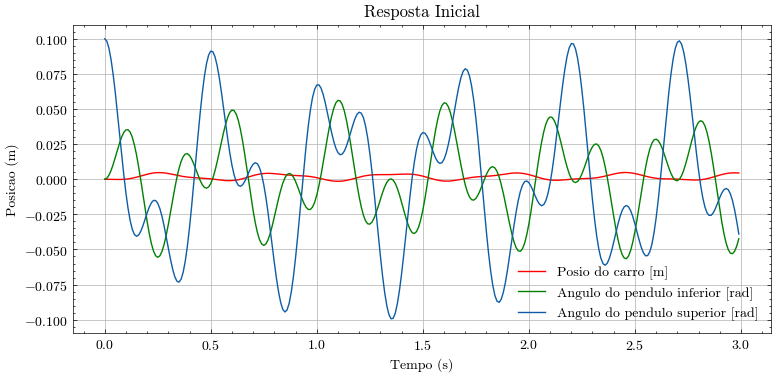

In [28]:

altura = 4
largura = 9

plt.style.use(['science','no-latex'])
#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posio do carro [m]')
subplots[1].plot(t,y[1], '-g',label='Angulo do pendulo inferior [rad]')
subplots[1].plot(t,y[2], label='Angulo do pendulo superior [rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



/workspaces/Projeto_TCC_DPI_Thalyson/.conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 231 (\N{LATIN SMALL LETTER C WITH CEDILLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/Projeto_TCC_DPI_Thalyson/.conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 227 (\N{LATIN SMALL LETTER A WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/Projeto_TCC_DPI_Thalyson/.conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 226 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


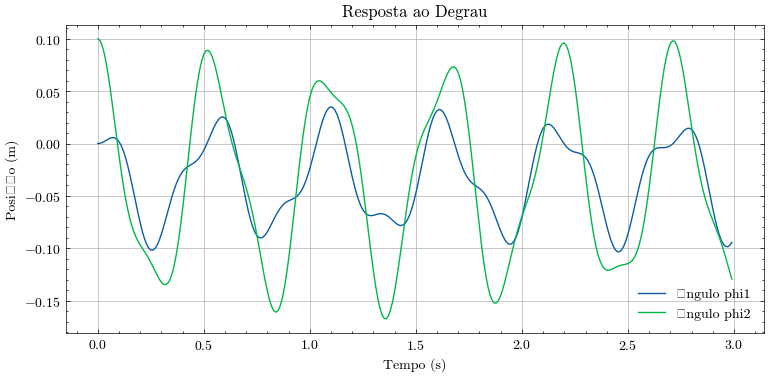

In [29]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='ângulo phi1')
subplots[1].plot(t,d[2][0], label='ângulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

# 4 Filtro de Kalman

In [47]:
# Sistema aumentado com pertubações e ruidos
A_k = A
B_k = B
C_k = C = np.array([1,0,0,0,0,0])

Vd = 0.1*np.eye(6) # covariância de pertubação
Vn = 0.5 # covariância de ruido

In [48]:
#Entradas aumentadas com pertubação e ruido
Bf = np.hstack((B, Vd, np.zeros_like(B))) 

# Cria um grande sistema em espaço de estados com uma entrada simples
sysC = ct.ss(A_k, Bf, C_k, np.array([0,0,0,0,0,0,0, Vn]))

# Sistema com todas as saidas de estado, pertubações e sem ruido
SysFullOutput = ct.ss(A,Bf, np.eye(6),np.zeros([6,np.size(Bf,1)]))

In [49]:
# Criando um Filtro de Kalman

# Design do Filtro
[L,P,E] = ct.lqe(A_k,Vd,C_k,Vd,Vn)

# Alternativamente, possivel construir usando "ct.lqr"
Kf,_,_= ct.lqr(np.transpose(A_k),np.transpose([C_k]),Vd,Vn)
K_lqr=np.transpose([Kf[0]])

# Estimador Filtro de Kalman
sysKF = ct.ss(A_k - L * C_k,np.hstack((B_k,L)), np.eye(6),0 )



In [50]:
L

array([[ 0.30526702],
       [-0.05167715],
       [-0.00438086],
       [ 0.04559398],
       [-0.01577479],
       [-0.00130849]])

In [51]:
# Sistema linearizado estimado na posiçao "caida" 
dt = 0.01
t = np.arange(0,10,dt)

uDIST = np.random.randn(6, len(t))
uNOISE = np.random.randn(len(t))

u = np.zeros_like(t)

# Atribuindo valores ao array u
u[99:120] = 1 # Impulso positivo
u[1499:1520] = -1 # Impulso negativo

uAUG = np.vstack((u,Vd @ Vd @ uDIST,uNOISE))



In [52]:

t,y = ct.forced_response(sysC,t,uAUG)
u_entrada = np.vstack((u, np.transpose(y[0])))

t,xtrue = ct.forced_response(SysFullOutput,t,uAUG)

t,x = ct.forced_response(sysKF,t,u_entrada)


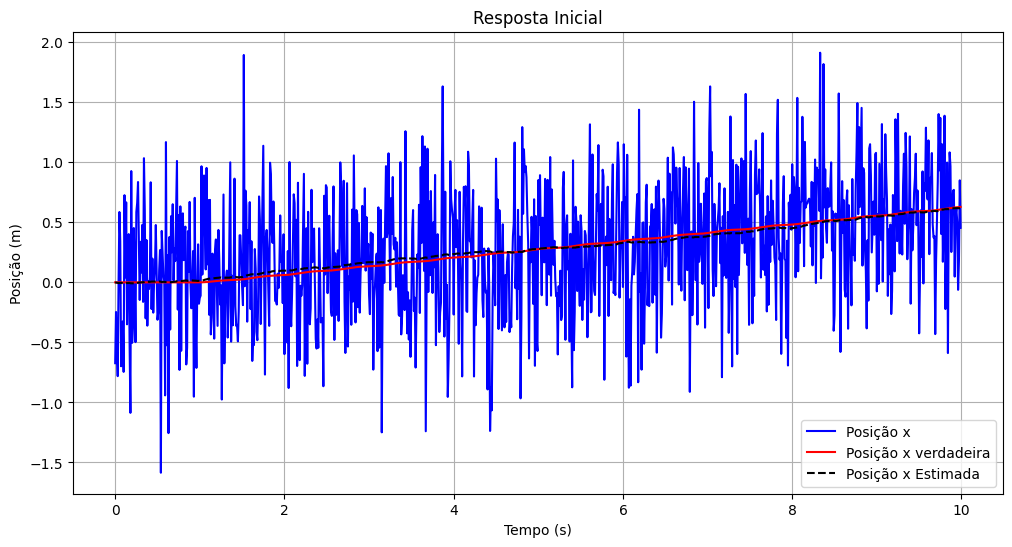

In [53]:
subplots = plt.subplots(1, 1, figsize=(12, 6))
subplots[1].plot(t,y[0],'b', label='Posição x')
subplots[1].plot(t,xtrue[0],'-r', label='Posição x verdadeira')
subplots[1].plot(t,x[0],'--k', label='Posição x Estimada')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

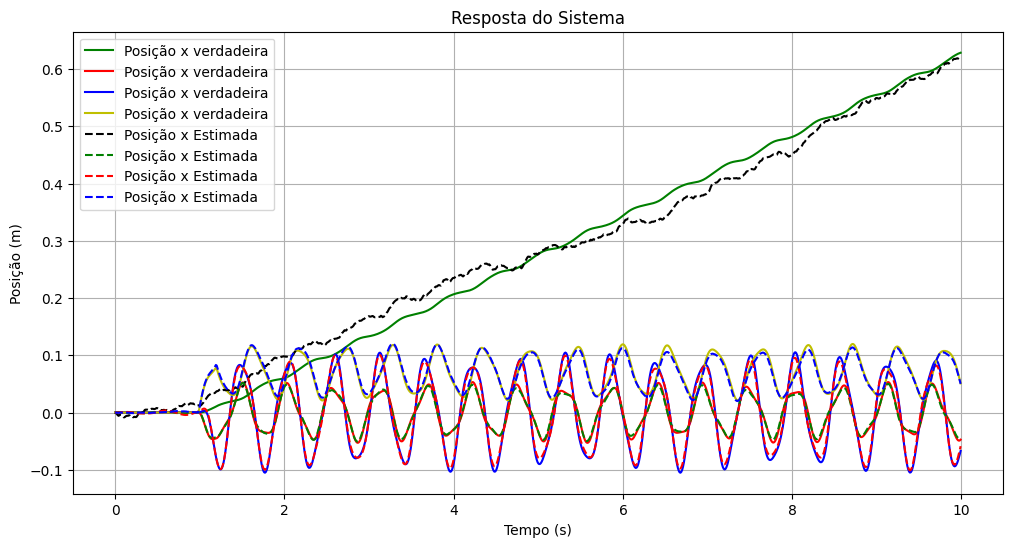

In [54]:
subplots = plt.subplots(1, 1, figsize=(12, 6))
subplots[1].plot(t,xtrue[0],'-g', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[1],'-r', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[2],'-b', label='Posição x verdadeira')
subplots[1].plot(t,xtrue[3],'-y', label='Posição x verdadeira')
subplots[1].plot(t,x[0],'--k', label='Posição x Estimada')
subplots[1].plot(t,x[1],'--g', label='Posição x Estimada')
subplots[1].plot(t,x[2],'--r', label='Posição x Estimada')
subplots[1].plot(t,x[3],'--b', label='Posição x Estimada')
subplots[1].set_title('Resposta do Sistema')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()